In [42]:
import os
import numpy as np
import pydicom
import nibabel as nib
import SimpleITK as sitk
import pandas as pd
import matplotlib.pyplot as plt

# 0.0 Define parameters

In [3]:
parent_dir = "/Users/u0126415/Documents/各种合作/Bo_Kyoung/Data/Data_Jul_30_2024/DCIS 5 samples"
dicom_folder = "Original"
seg_folder = "segmentation"

nii_dir = "/Users/u0126415/Documents/各种合作/Bo_Kyoung/Data/Data_Jul_30_2024/converted_Nifti"

for i in [nii_dir]:
    if not os.path.exists(i):
        os.makedirs(i)

# 1.0 Conversion img file into nifti file

In [12]:
def convert_analyze_to_nifti(img_file_path, output_file_path):
    # Load the Analyze format (.img and .hdr) file using nibabel
    img = nib.load(img_file_path)
    
    # Save the data as a NIfTI file
    nib.save(img, output_file_path)
    print(f"Converted {img_file_path} to {output_file_path}")

In [13]:
# Walk through all the files and folders in the specified directory
for root, dirs, files in os.walk(os.path.join(parent_dir,seg_folder)):
    if dirs == []:
        dicom_path = root

        case = root.split("/")[-2]
        scan = root.split("/")[-1]
        print(case,scan)

        #------------------------------------------------#
        #Naming convention by checking file list
        scan_path = os.path.join(root,f"{scan}.img")
        seg_path = os.path.join(root,f"l{scan}.img")
        
        #------------------------------------------------#
        nii_path = os.path.join(nii_dir,case)
        if not os.path.exists(nii_path):
            os.makedirs(nii_path)

        nii_path_scan = f"{nii_path}/{scan}_scan.nii.gz"
        nii_path_seg = f"{nii_path}/{scan}_seg.nii.gz"

        #------------------------------------------------#
        if not os.path.exists(nii_path_scan):
            convert_analyze_to_nifti(scan_path, nii_path_scan)
        if not os.path.exists(nii_path_seg):
            convert_analyze_to_nifti(seg_path, nii_path_seg)

DICS064 DICS064_UF2
Converted /Users/u0126415/Documents/各种合作/Bo_Kyoung/Data/Data_Jul_30_2024/DCIS 5 samples/segmentation/DICS064/DICS064_UF2/DICS064_UF2.img to /Users/u0126415/Documents/各种合作/Bo_Kyoung/Data/Data_Jul_30_2024/converted_Nifti/DICS064/DICS064_UF2_scan.nii.gz
Converted /Users/u0126415/Documents/各种合作/Bo_Kyoung/Data/Data_Jul_30_2024/DCIS 5 samples/segmentation/DICS064/DICS064_UF2/lDICS064_UF2.img to /Users/u0126415/Documents/各种合作/Bo_Kyoung/Data/Data_Jul_30_2024/converted_Nifti/DICS064/DICS064_UF2_seg.nii.gz
DICS064 DICS064_UF3
Converted /Users/u0126415/Documents/各种合作/Bo_Kyoung/Data/Data_Jul_30_2024/DCIS 5 samples/segmentation/DICS064/DICS064_UF3/DICS064_UF3.img to /Users/u0126415/Documents/各种合作/Bo_Kyoung/Data/Data_Jul_30_2024/converted_Nifti/DICS064/DICS064_UF3_scan.nii.gz
Converted /Users/u0126415/Documents/各种合作/Bo_Kyoung/Data/Data_Jul_30_2024/DCIS 5 samples/segmentation/DICS064/DICS064_UF3/lDICS064_UF3.img to /Users/u0126415/Documents/各种合作/Bo_Kyoung/Data/Data_Jul_30_2024/con

# 2.0 Co-registration

In [18]:
def co_register_images(fixed_image_path, moving_image_path, output_image_path):
    # Read the fixed and moving images
    fixed_image = sitk.ReadImage(fixed_image_path, sitk.sitkFloat32)
    moving_image = sitk.ReadImage(moving_image_path, sitk.sitkFloat32)
    
    # Initialize the registration method
    registration_method = sitk.ImageRegistrationMethod()
    
    # Similarity metric settings
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    
    # Rigid transform settings
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()
    
    # Interpolator
    registration_method.SetInterpolator(sitk.sitkLinear)
    
    # Initial transform using center of mass
    initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                          moving_image, 
                                                          sitk.Euler3DTransform(), 
                                                          sitk.CenteredTransformInitializerFilter.GEOMETRY)
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    
    # Execute the registration
    final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                  sitk.Cast(moving_image, sitk.sitkFloat32))
    
    # Resample the moving image using the final transform
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(fixed_image)
    resample.SetInterpolator(sitk.sitkLinear)
    resample.SetDefaultPixelValue(0)
    resample.SetTransform(final_transform)
    
    registered_image = resample.Execute(moving_image)
    
    # Save the registered image
    sitk.WriteImage(registered_image, output_image_path)
    print(f"Registered image saved as {output_image_path}")

In [27]:
for root, dirs, files in os.walk(nii_dir):
    cond_1 = dirs == []
    if cond_1:
        
        case = root.split("/")[-1]
        print(f"Processing: {case}")

        #------------------------------------------------#
        postT1early_seg_path = os.path.join(root,f"{case}_PostT1early_seg.nii.gz")
        other_segs = [x for x in os.listdir(root) if "seg" in x and not x.startswith(".") and x != f"{case}_PostT1early_seg.nii.gz"]

        for seg in other_segs:
            seg_path = os.path.join(root,seg)


            parts = seg.split('.')
    
            # Modify the first part
            parts[0] = parts[0] + '_Co_re'
            
            # Join the parts back together with a period (.)
            modified_seg = '.'.join(parts)
            seg_path_co_re = os.path.join(root,modified_seg)  #output nii file by moving PostT1early to iterative "seg"

            co_register_images(seg_path, postT1early_seg_path, seg_path_co_re)

Processing: DICS064
Registered image saved as /Users/u0126415/Documents/各种合作/Bo_Kyoung/Data/Data_Jul_30_2024/converted_Nifti/DICS064/DICS064_UF3_seg_Co_re.nii.gz
Registered image saved as /Users/u0126415/Documents/各种合作/Bo_Kyoung/Data/Data_Jul_30_2024/converted_Nifti/DICS064/DICS064_UF1_seg_Co_re.nii.gz
Registered image saved as /Users/u0126415/Documents/各种合作/Bo_Kyoung/Data/Data_Jul_30_2024/converted_Nifti/DICS064/DICS064_UF2_seg_Co_re.nii.gz
Registered image saved as /Users/u0126415/Documents/各种合作/Bo_Kyoung/Data/Data_Jul_30_2024/converted_Nifti/DICS064/DICS064_DWI_seg_Co_re.nii.gz
Registered image saved as /Users/u0126415/Documents/各种合作/Bo_Kyoung/Data/Data_Jul_30_2024/converted_Nifti/DICS064/DICS064_T2_seg_Co_re.nii.gz
Registered image saved as /Users/u0126415/Documents/各种合作/Bo_Kyoung/Data/Data_Jul_30_2024/converted_Nifti/DICS064/DICS064_PreT1_seg_Co_re.nii.gz
Registered image saved as /Users/u0126415/Documents/各种合作/Bo_Kyoung/Data/Data_Jul_30_2024/converted_Nifti/DICS064/DICS064_PostT1

# 3.0 Statistics by Dice similarity co-efficient

In [32]:
def get_original_filename(modified_filename):
    # Split the filename into parts using '.' as the delimiter
    parts = modified_filename.split('.')
    
    # Modify the first part by removing the '_kk' suffix
    parts[0] = parts[0].replace('_Co_re', '')
    
    # Join the parts back together to form the original filename
    original_filename = '.'.join(parts)
    
    return original_filename

In [28]:
def calculate_dice_coefficient(nifti_file_1, nifti_file_2):
    # Load the NIfTI files
    img1 = nib.load(nifti_file_1)
    img2 = nib.load(nifti_file_2)
    
    # Get the data arrays
    data1 = img1.get_fdata()
    data2 = img2.get_fdata()
    
    # Ensure the two images have the same shape
    if data1.shape != data2.shape:
        raise ValueError("The two NIfTI files must have the same shape.")
    
    # Calculate the intersection and the sums of the two sets
    intersection = np.sum((data1 > 0) & (data2 > 0))
    sum1 = np.sum(data1 > 0)
    sum2 = np.sum(data2 > 0)
    
    # Calculate the Dice Similarity Coefficient
    dice_coefficient = (2. * intersection) / (sum1 + sum2)
    
    return dice_coefficient

In [38]:
output_dict = {}

for root, dirs, files in os.walk(nii_dir):
    cond_1 = dirs == []
    if cond_1:
        
        case = root.split("/")[-1]
        print(f"Processing: {case}")

        #------------------------------------------------#

        co_re_segs = [x for x in os.listdir(root) if "_Co_re" in x and not x.startswith(".")]
        original_segs = [get_original_filename(x) for x in co_re_segs]

        for co_re_seg,original_seg in zip(co_re_segs,original_segs):
            co_re_seg_path = os.path.join(root,co_re_seg)
            original_seg_path = os.path.join(root,original_seg)

            Dice = calculate_dice_coefficient(co_re_seg_path,original_seg_path)

            modality_name = original_seg.split("_")[1]
            print(f"{modality_name}")
            print(f"{Dice:.2f}")
            print("")

        #------------------------------------------------#
            if modality_name not in output_dict.keys():  
                output_dict[modality_name] = []
            else:
                output_dict[modality_name].append(Dice)

Processing: DICS064
UF2
0.62

PostT1delay
0.85

UF3
0.65

DWI
0.62

PreT1
0.85

T2
0.76

UF1
0.66

Processing: DICS133
T2
0.69

PostT1delay
0.87

UF2
0.66

PreT1
0.87

DWI
0.35

UF3
0.66

UF1
0.66

Processing: DICS070
PreT1
0.60

UF1
0.40

UF3
0.30

DWI
0.16

PostT1delay
0.79

T2
0.47

UF2
0.40

Processing: DICS072
DWI
0.34

UF3
0.68

UF2
0.70

PostT1delay
0.84

PreT1
0.77

UF1
0.70

T2
0.59

Processing: DICS073
PreT1
0.84

UF2
0.52

UF3
0.53

DWI
0.61

PostT1delay
0.84

UF1
0.54

T2
0.59



In [43]:
df = pd.DataFrame.from_dict(output_dict)
df

,UF2,PostT1delay,UF3,DWI,PreT1,T2,UF1
0,0.656238,0.866062,0.659242,0.347895,0.866062,0.693439,0.657401
1,0.403664,0.785444,0.298999,0.155311,0.595790,0.470738,0.395816
2,0.698255,0.842656,0.681072,0.338542,0.770400,0.590008,0.695295
3,0.521527,0.840920,0.533094,0.611809,0.840920,0.594950,0.541453


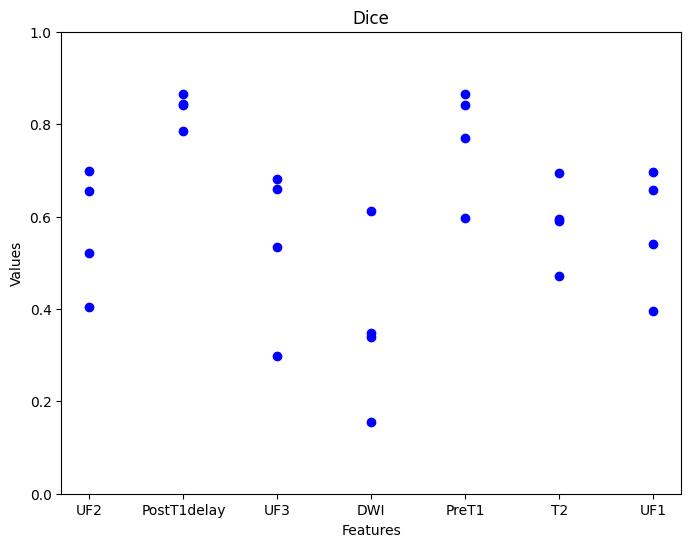

In [56]:
# Create a scatter plot
plt.figure(figsize=(8, 6))

# Define a color for all points
common_color = 'blue'

# Plot each row as a separate group with the same color
for i in range(len(df)):
    plt.scatter(df.columns, df.iloc[i], label=f'Row {i+1}', color=common_color)


# Add labels and legend
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Dice')
# Set y-axis limits
plt.ylim(0, 1)

plt.savefig(f"{parent_dir}/Dice.jpg", bbox_inches='tight')

# Show the plot
plt.show()

<Figure size 640x480 with 0 Axes>